In [1]:
## import libraries needed for simulations

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal as mvn
from scipy.stats import kstest
from scipy.stats import logistic
from scipy.stats import uniform as unif 
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange
import time 

C:\Users\Jason\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Simulate the Fisher Information for the Median (new):

In [2]:
np.random.seed(333)

In [3]:
# helper functions to help transform correlation, FI data later

def mean_getter_cor(list_of_lists):
    means = []
    for templist in list_of_lists:
        means.append(np.mean(np.square(templist)))
    return np.array(means)

def q_getter_cor(list_of_lists, q=0.975):
    qs = []
    for templist in list_of_lists:
        qs.append(np.quantile(np.square(templist), q))
    return np.array(qs)

def stdev_getter_cor(list_of_lists):
    stdev = []
    for templist in list_of_lists:
        stdev.append(np.sqrt(np.var(np.square(templist))))
    return np.array(stdev)


def mean_getter_FI(list_of_lists):
    means = []
    for templist in list_of_lists:
        means.append(np.mean(1/np.array(templist)))
    return np.array(means)

def q_getter_FI(list_of_lists, q=0.975):
    qs = []
    for templist in list_of_lists:
        qs.append(np.quantile(1/np.array(templist), q))
    return np.array(qs)

def stdev_getter_FI(list_of_lists):
    stdev = []
    for templist in list_of_lists:
        stdev.append(np.sqrt(np.var(1/np.array(templist))))
    return np.array(stdev)

In [4]:
def FI_sim(num_sims = 10000, n=100, N=1000):
    """
    Given the number of simulations (num_sims),
        sample size (n), and population size (N),
        simulates drawing the population, then 
            drawing a sample with SRS from the model
            described in Section 4.2, and then
            saves the results if at least one
            sample point is between the sample
            and population median.
        
    Returns 4 lists of length < num_sims:
       FI_final: Simulated Fisher Info.
       num_bet_final: Simulated number of sample points
           between the mean and median
       corr_final: Simulated correlation between the estimating
           equations and the R-mechanism
       err_final: saves the final error between the population
           and sample median.       
    """
    
    FI_final = []
    num_bet_final = []
    err_final = []
    corr_final = []
    
    for _ in trange(num_sims):
        # simulate population, then sample!
        cur_pop = np.exp(logistic.rvs(loc=np.log(1/0.991), scale=1/1.623, size=N))
        cur_samp = cur_pop[:n]
        
        cur_pop_med = np.median(cur_pop)
        cur_samp_med = np.median(cur_samp)
        
        # record results
        if cur_pop_med < cur_samp_med:
            num_bet = np.sum((cur_samp < cur_samp_med) & (cur_samp > cur_pop_med))
            if num_bet == 0:
                continue
            num_bet_final.append(num_bet)
            FI_final.append(num_bet/(cur_samp_med - cur_pop_med)/n)
            err_final.append(cur_samp_med - cur_pop_med)
            
        elif cur_pop_med > cur_samp_med:
            num_bet = np.sum((cur_samp < cur_pop_med) & (cur_samp > cur_samp_med))
            if num_bet == 0:
                continue
            num_bet_final.append(num_bet)
            FI_final.append(num_bet/(cur_pop_med - cur_samp_med)/n)
            err_final.append(cur_pop_med - cur_samp_med)

        corr_final.append((2*np.sum(cur_samp > cur_pop_med)-n) \
            /N/(np.sqrt((n/N)*(1-n/N))))
                
    return FI_final, num_bet_final, corr_final, err_final

In [5]:
def FI_sim_biased(num_sims = 10000, n=100, N=1000):
    """
    Given the number of simulations (num_sims),
        sample size (n), and population size (N),
        simulates drawing the population, then 
            drawing a sample with length-biased sampling
            from the model described in Section 4.2, 
            and then saves results if at least one
            sample point is between the sample
            and population median.
        
    Returns 4 lists of length < num_sims:
       FI_final: Simulated Fisher Info.
       num_bet_final: Simulated number of sample points
           between the mean and median
       corr_final: Simulated correlation between the estimating
           equations and the R-mechanism
       err_final: saves the final error between the population
           and sample median.       
    """
    
    FI_final = []
    num_bet_final = []
    err_final = []
    corr_final = []
    
    for _ in trange(num_sims):
        # simulate population, then sample!
        cur_pop = np.exp(logistic.rvs(loc=np.log(1/0.991), scale=1/1.623, size=N))
        cur_samp = np.random.choice(cur_pop, size=n, replace=False, p=cur_pop/np.sum(cur_pop))
        
        cur_pop_med = np.median(cur_pop)
        cur_samp_med = np.median(cur_samp)
        
        # record results
        if cur_pop_med < cur_samp_med:
            num_bet = np.sum((cur_samp < cur_samp_med) & (cur_samp > cur_pop_med))
            if num_bet == 0:
                continue
            num_bet_final.append(num_bet)
            FI_final.append(num_bet/(cur_samp_med - cur_pop_med)/n)
            err_final.append(cur_samp_med - cur_pop_med)
            
        elif cur_pop_med > cur_samp_med:
            num_bet = np.sum((cur_samp < cur_pop_med) & (cur_samp > cur_samp_med))
            if num_bet == 0:
                continue
            num_bet_final.append(num_bet)
            FI_final.append(num_bet/(cur_pop_med - cur_samp_med)/n)
            err_final.append(cur_pop_med - cur_samp_med)
        
        corr_final.append((2*np.sum(cur_samp > cur_pop_med)-n) \
            /N/(np.sqrt((n/N)*(1-n/N))))
        
    return FI_final, num_bet_final, corr_final, err_final

In [6]:
# precompute all (sample size, population size) pairs
startn = 10
startN = 100
scaleup = 2
scaletimes = 10

n_N_pairs = []
init_pair = np.array([startn, startN])
for i in range(scaletimes):
    n_N_pairs.append(init_pair*(scaleup**i))

In [7]:
# simulate and save all simulations for SRS sampling
agg_FIs = []
agg_bets = []
agg_corrs = []
agg_errors = []
for (n, N) in n_N_pairs:
    temp_FIs, temp_bets, temp_corrs, temp_errs = FI_sim(n=n, N=N)
    agg_FIs.append(temp_FIs)
    agg_bets.append(temp_bets)
    agg_corrs.append(temp_corrs)
    agg_errors.append(temp_errs)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
# simulate and save all simulations for length-biased sampling
bagg_FIs = []
bagg_bets = []
bagg_corrs = []
bagg_errors = []
for (n, N) in n_N_pairs:
    temp_FIs, temp_bets, temp_corrs, temp_errs = FI_sim_biased(n=n, N=N)
    bagg_FIs.append(temp_FIs)
    bagg_bets.append(temp_bets)
    bagg_corrs.append(temp_corrs)
    bagg_errors.append(temp_errs)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
# summarize all simulation data into one dataframe
agg_all_info = pd.DataFrame({
    "mean_FI": mean_getter_FI(agg_FIs),
    "uq_FI": q_getter_FI(agg_FIs),
    "lq_FI": q_getter_FI(agg_FIs, q=0.025),
    "bmean_FI": mean_getter_FI(bagg_FIs),
    "buq_FI": q_getter_FI(bagg_FIs),
    "blq_FI": q_getter_FI(bagg_FIs, q=0.025),
    "std_FI": stdev_getter_FI(agg_FIs),
    "bstd_FI": stdev_getter_FI(bagg_FIs),
    "mean_cor2": mean_getter_cor(agg_corrs),
    "uq_cor2": q_getter_cor(agg_corrs),
    "lq_cor2": q_getter_cor(agg_corrs, q=0.025),
    "bmean_cor2": mean_getter_cor(bagg_corrs),
    "buq_cor2": q_getter_cor(bagg_corrs),
    "blq_cor2": q_getter_cor(bagg_corrs, q=0.025),
    "std_cor2": stdev_getter_cor(agg_corrs),
    "bstd_cor2": stdev_getter_cor(bagg_corrs),
})

# set index to log-population size
N_s = [temp_N for (n, temp_N) in n_N_pairs]
agg_all_info.index = np.log(N_s)

In [10]:
# sanity check
agg_all_info.head(3).T

,4.605170,5.298317,5.991465
mean_FI,2.507736,2.651465,2.701553
uq_FI,7.634672,7.616106,7.354326
lq_FI,0.384859,0.440714,0.524857
bmean_FI,6.608171,5.905220,5.560150
buq_FI,18.207324,12.663603,9.674093
blq_FI,1.572166,2.174108,2.797131
std_FI,2.006710,1.891274,1.794672
bstd_FI,4.547266,2.762820,1.776558
mean_cor2,0.013553,0.006182,0.002912
uq_cor2,0.040000,0.027778,0.013611


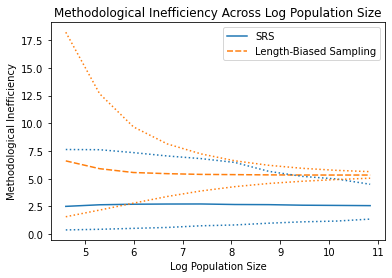

In [13]:
# plotting methodological inefficiency
sns.lineplot(data=agg_all_info[["mean_FI", "bmean_FI"]])

# quantiles for SRS simulations
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["uq_FI"], \
             color=sns.color_palette()[0], linestyle="dotted")
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["lq_FI"], \
             color=sns.color_palette()[0], linestyle="dotted")

# quantiles for length-biased simulations
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["buq_FI"], \
             color=sns.color_palette()[1], linestyle="dotted")
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["blq_FI"], \
             color=sns.color_palette()[1], linestyle="dotted")

plt.legend(["SRS", "Length-Biased Sampling"])
plt.title("Methodological Inefficiency Across Log Population Size")
plt.xlabel("Log Population Size")
plt.ylabel("Methodological Inefficiency")
plt.savefig("ch4_2_method_inefficiency.png")

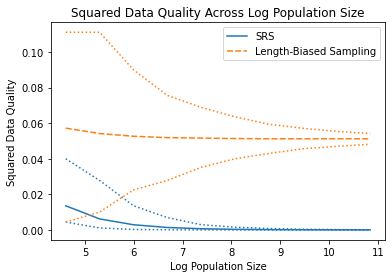

In [14]:
# plotting Squared Data Quality (Data Defect Index)
sns.lineplot(data=agg_all_info[["mean_cor2", "bmean_cor2"]]) 

# quantiles for SRS simulations
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["uq_cor2"], \
             color=sns.color_palette()[0], linestyle="dotted")
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["lq_cor2"], \
             color=sns.color_palette()[0], linestyle="dotted")

# quantiles for length-biased simulations
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["buq_cor2"], \
             color=sns.color_palette()[1], linestyle="dotted")
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["blq_cor2"], \
             color=sns.color_palette()[1], linestyle="dotted")

plt.legend(["SRS", "Length-Biased Sampling"])
plt.title("Squared Data Quality Across Log Population Size")
plt.xlabel("Log Population Size")
plt.ylabel("Squared Data Quality")
plt.savefig("ch4_2_method_quality.png")